In [41]:
"""
Created on Wed Jun 19 17:45:50 2019

@author: ggusmao3
"""

'\nCreated on Wed Jun 19 17:45:50 2019\n\n@author: ggusmao3\n'

-*- coding: utf-8 -*-

In [42]:
from __future__ import print_function, division, absolute_import
import jax.numpy as np
from numpy.random import choice
from jax import grad, jit, vmap, jacobian, jacfwd, jacrev
from jax import random
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.config import config
from jax.tree_util import tree_map
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import itertools

In [43]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

In [44]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_model_params(m, key, scale=1e-2):
    #w_key, b_key = random.split(key)
    #print(tuple(scale * random.normal(key, (m, 1))))
    return (scale * random.normal(key, (m,)))#, scale * random.normal(b_key, (n,))

In [45]:
# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [46]:
def init_model_params(size, key, scale):
 key = random.split(key,2)[-1] 
 return [random_model_params(s, key, scale) for s in size]

In [47]:
@jit
def transfer_fun(x):
    #return np.maximum(0, x)
    #return np.nan_to_num(x / (1.0 + np.exp(-x)))
    #return x / (1.0 + np.exp(-x))
    return 2./(1.+np.exp(-2.*x))-1.
    #return 0.5*np.tanh(x) + 0.5*x / (1.0 + np.exp(-x))
    #return(x)

In [48]:
@jit
def state(params, t):
    # per-example stateions
    activations = t
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = transfer_fun(outputs)
    
    final_w, final_b = params[-1]
    y = (np.dot(final_w, activations) + final_b)
    #y = y / y.sum()
    return y

# Make a batched version of the `state` function
batched_state = vmap(state, in_axes=(None,0))#, in_axes=(None, 0))

In [49]:
@jit
def diff_state(params,t):
        i = np.arange(len(t))
        #return (jacobian(batched_state,argnums=1)(params,t)[i,:,i,0])
        return np.nan_to_num(jacfwd(lambda t : batched_state(params,t))(t)[i,:,i,0])

In [50]:
model_params0 = np.array([1.,1.])
bc0=np.array([1.0,0.0,0.0])

In [51]:
@jit
def model(batch, model_params):
    #print('model x: {}'.format(x))
    #print('model params: {}'.format(model_params))
    x, t = batch
    k  = model_params
    return np.array([[-k[0]*x[0]],
                    [k[0]*x[0]-k[1]*x[1]],
                    [k[1]*x[1]]])

batched_model = lambda batch, model_params : vmap(model,in_axes=(0,None))(batch,model_params)[:,:,0]#, in_axes=(None, 0)

CPU times: user 53.5 ms, sys: 0 ns, total: 53.5 ms
Wall time: 46.9 ms


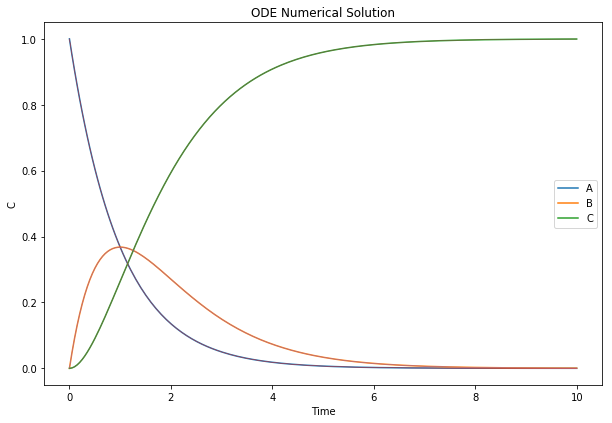

In [191]:
%%time

tmax = 10.
t = np.logspace(0,np.log10(tmax+1),12).reshape((-1,1))-1.
from scipy.integrate import solve_ivp

def ode(t,C):
    return model([C,t], model_params0).flatten()

n_points = int(20*tmax)

#t_eval = np.logspace(0,np.log10(tmax),n_points)-1.
t_eval = np.linspace(0,tmax,n_points)
sol = solve_ivp(ode, (0, tmax), bc0, t_eval = t_eval)

plt.figure(figsize=[10,10*2./3])
t = sol.t
x0 = sol.y.T
x = x0
lines = plt.plot(sol.t, x0)
plt.plot(sol.t, x,'-',ms=5,lw=0.5)
plt.xlabel('Time')
plt.ylabel('C');
plt.legend(iter(lines), ['A', 'B', 'C'])
plt.title('ODE Numerical Solution')

t = t.reshape(-1,1)
data = t

In [170]:
@jit
def get_errors(nn_params,batch):
    t = batch
    pred_x = batched_state(nn_params,t)
    err_model = (diff_state(nn_params,t)-batched_model([pred_x,t.reshape(-1,1)],model_params0))**2 
    err_bc = 100*(batched_state(nn_params,np.array(0).reshape(-1,1))-bc0)**2
    return [err_model, err_bc]

In [171]:
@jit
def loss(nn_params, batch):
    return np.array([_.sum() for _ in get_errors(nn_params,batch)]).sum()

In [172]:
layer_sizes = [1, 20, 3]
nn_scale = 0.01

key = random.PRNGKey(0)

nn_params = init_network_params(layer_sizes, key, nn_scale)

In [181]:
num_epochs = 100
num_eras = int(1e1)
batch_size = n_points
model_params = model_params0

In [182]:
opt_init_nn, opt_update_nn, get_params_nn = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
    
@jit
def step(i, opt_state_nn, batch):
    nn_params = get_params_nn(opt_state_nn)
    grads_nn = grad(loss,argnums=0)(nn_params, batch)  
    return opt_update_nn(i, grads_nn, opt_state_nn)
 
itercount = itertools.count()        

opt_state_nn = opt_init_nn(nn_params)

for j in range(num_eras):
    sel = random.shuffle(random.PRNGKey(j),np.arange(n_points))    
    batch = data[:batch_size]
    for i in range(int(num_epochs)):
        nn_params = get_params_nn(opt_state_nn)
        opt_state_nn = step(next(itercount), opt_state_nn, batch) 
    nn_params = get_params_nn(opt_state_nn) 
    loss_it_sample = loss(nn_params, batch)    
    loss_it_batch = loss(nn_params, data)
    err_model, err_bc = [_.sum() for _ in get_errors(nn_params,data)]
    print('Iteration: {:4d}, Loss Batch: {:.5e}, Loss Data: {:.5e}, Fit Model: {:.5e}'.format(i,loss_it_sample,loss_it_batch,err_model))
    clear_output(wait=True)    

Iteration:   99, Loss Batch: 1.13877e-03, Loss Data: 1.13877e-03, Fit Model: 1.13869e-03


[DeviceArray(1.), DeviceArray(1.)]

[DeviceArray(1.), DeviceArray(1.)]

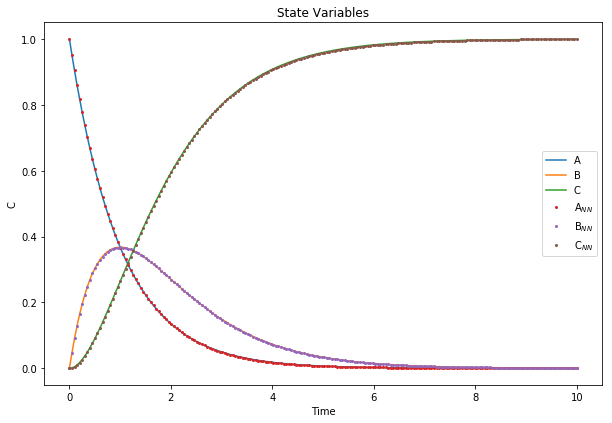

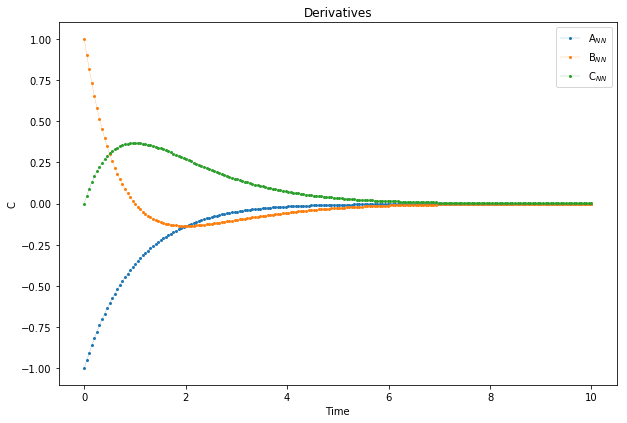

In [192]:
plt.figure(figsize=[10,10*2./3])
nn_params = get_params_nn(opt_state_nn)
lines = plt.plot(sol.t, x0)
lines += plt.plot(t,batched_state(nn_params, t),'o',lw=0.2,ms=2)
plt.legend(iter(lines), ['A', 'B', 'C','A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.figure(figsize=[10,10*2./3])
plt.plot(t,batched_model([batched_state(nn_params,t),t],model_params0),'-o',lw=0.2,ms=2)
plt.legend(['A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Derivatives')
plt.xlabel('Time')
plt.ylabel('C');


display([(_) for _ in model_params])
display([(_) for _ in model_params0])
#plt.gca().set_yscale('log')